In [3]:
%%capture output
%run "3. Feature Engineering, Extraction and Selection.ipynb"
print('Operation complete')

# Model Selection and Evaluation

## Importing dependencies

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix, precision_score, accuracy_score
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
from sklearn.multiclass import OneVsRestClassifier

#models
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

## Modeling

### Model Selection

After creating the classification model objects, I will proceed by performing a k=10 cross-validation

In [5]:
# creating the objects
NB = GaussianNB()
MNB = MultinomialNB()
LR = LogisticRegression(random_state=1)
SV = SVC()
DT = DecisionTreeClassifier()
RF = RandomForestClassifier()
XGB = xgb.XGBClassifier()
KNN = KNeighborsClassifier()
# model.get_params()

### Which model should i pick?

To have a really general idea on our models let's run our models firstly on all the data, then on the train and test sets respectively.

In [6]:
X = tfidf.fit_transform(data['Clean Review']).toarray()
y = data['Target']

crossval_dict = {0: 'Naive Bayes', 
                1: 'Multinomial Naive Bayes',
                2: 'Logistic Regression',
                3: 'SVC',
                4: 'Decision Tree',
                5: 'Random Forest',
                6: 'XGBoost',
                7: 'KNN'}
crossval_models=[NB, MNB, LR, SV, DT, RF, XGB, KNN]

# iterate over all the models computing the general accuracy on all the data
for i, model in enumerate(crossval_models):
    print("{} Trial Accuracy: {}".format(crossval_dict[i], cross_val_score(model, X, y, cv=10, scoring ='accuracy').mean()))

Naive Bayes Trial Accuracy: 0.854054054054054
Multinomial Naive Bayes Trial Accuracy: 0.8689189189189189
Logistic Regression Trial Accuracy: 0.8756756756756758
SVC Trial Accuracy: 0.8729729729729729
Decision Tree Trial Accuracy: 0.8445945945945945
Random Forest Trial Accuracy: 0.8797297297297298
XGBoost Trial Accuracy: 0.8891891891891893
KNN Trial Accuracy: 0.895945945945946


Cross_val_score is a function from scikit-learn that outputs the average accuracy by performing cross-validation: it splits the data into multiple folds and evaluates the model's performance on each fold, in this case 10 folds. 

Now looking at the results, we notice that all the accuracies are between 80% and 90%. Therefore it is necessary to compare the models from different points of view. Let's take a look at more specific metrics for classification tasks such as precision and F1 for each non optimized model.

In [7]:
print('------------------TRAIN SET------------------')
results = []
for i, model in enumerate(crossval_models):
    # train the models
    model.fit(X_train, y_train)

    # compute metrics and append them to the results list
    accuracy = model.score(X_train, y_train)
    precision = precision_score(y_train, model.predict(X_train), average="micro")
    f1 = f1_score(y_train, model.predict(X_train), average="weighted")
    results.append({'Model': crossval_dict[i], 'Accuracy': accuracy, 'Precision': precision, 'F1': f1})

df_results = pd.DataFrame(results)
df_results

------------------TRAIN SET------------------


,Model,Accuracy,Precision,F1
0,Naive Bayes,0.997050,0.997050,0.997050
1,Multinomial Naive Bayes,0.990413,0.990413,0.990377
2,Logistic Regression,1.000000,1.000000,1.000000
3,SVC,1.000000,1.000000,1.000000
4,Decision Tree,1.000000,1.000000,1.000000
5,Random Forest,1.000000,1.000000,1.000000
6,XGBoost,1.000000,1.000000,1.000000
7,KNN,0.689528,0.689528,0.585650


The F1 suggests that the KNN, which was the best in the previous output, is now the worst model. Seems like the models are generally overfitting the training data. To show an example of overfitting in this case we will use the decision tree, which is simple to visualize.

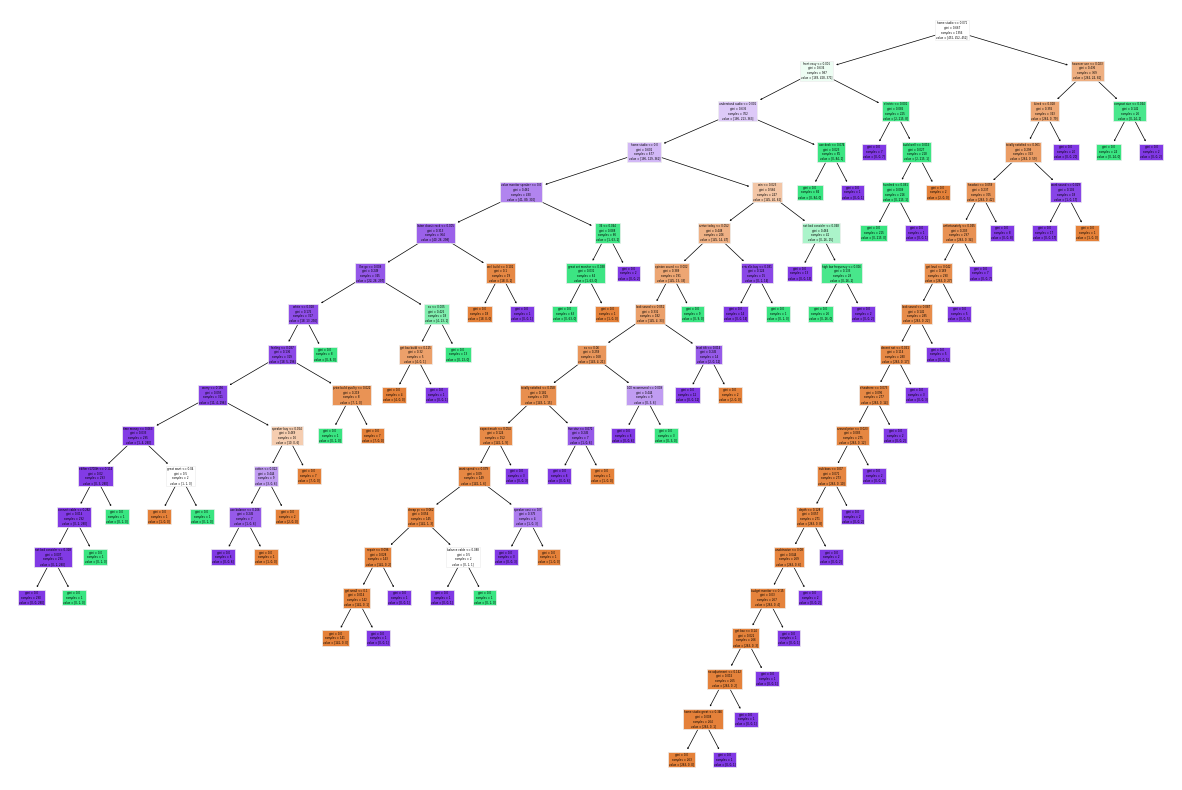

In [8]:
DT.fit(X_train, y_train)
plt.figure(figsize=(15,10))
plot_tree(decision_tree=DT, feature_names=tfidf.get_feature_names(), filled=True)
plt.show()

In the leaves we probably have just single observations/reviews. We need a much more generalized tree.

### Hyperparameter tuning

Let's apply different random configurations to see how to model's accuracy changes in train and test sets. We need to pay attention to how the accuracies are similar when we reduce the model's complexity. We should pick up a good configuration based on the test accuracy.

For the hyperparameter tuning there are different approaches, but in this analysis I will use the Grid Search Optimization: it creates a grid-like structure with all possible combinations of the predefined set of hyperparameters and evaluates each combination using **cross-validation** (or a separate validation set), which will help to reduce the overfitting. Since in some case it takes too much time, I will implement a Randomized Search which works in the same way as the Grid Search but only on a random subset of the combinations.

We will do hyperparameter optimization on:
- Logistic Regression
- Random Forest
- SVC
- XGBoost

In [23]:
# defining a hyperparameter tuning function
def hypertuning(classifier, param_grid, metric='accuracy', verbose_value=1):
    cv_method = KFold(n_splits=5, shuffle=True)     # creating a 5 cross-k-validation method
    model = RandomizedSearchCV(
            estimator = classifier,
            param_distributions = param_grid,
            n_iter = 10,
            scoring = metric,
            n_jobs = -1, 
            cv = cv_method, 
            verbose = verbose_value, 
            random_state = 1)
    
    # then fit the new model and get the best model
    model.fit(X_train, y_train)

    # create the new fine tuned model
    best_model = model.best_estimator_

    # best score
    print(f"Best Score: {model.best_score_}")       # best_score_ is the average of all cv folds for a single combination of the parameters
    
    # hyperparams found
    print("Hyperparameter set:")
    best_parameters = model.best_estimator_.get_params()
    for param_name in sorted(param_grid.keys()):        # for loop to have them printed nicely
        print(f"\t{param_name}: {best_parameters[param_name]}")
    
    # accuracy
    y_pred = best_model.predict(X_test)
    print(f'Tuned LR accuracy on test set is: {accuracy_score(y_test, y_pred)}')
    print(f'Tuned LR F1 score on test set is: {f1_score(y_test, y_pred, average="weighted")}')

    # confusion matrix
    y_pred = best_model.predict(X_test)
    confusion = confusion_matrix(y_test, y_pred)
    confusion_matrix_plot(confusion, classes=['Negative','Neutral','Positive'])
    return best_model

In [10]:
# defining a function to plot the 3x3 confusion matrix
def confusion_matrix_plot(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Tuning Logistic Regression

In [11]:
LR.fit(X_train, y_train)
y_pred = LR.predict(X_test)
print(f'Base LR accuracy on test set is: {accuracy_score(y_test, y_pred)}')
print(f'Base LR F1 score on test set is: {f1_score(y_test, y_pred, average="weighted")}')

Base LR accuracy on test set is: 0.9009009009009009
Base LR F1 score on test set is: 0.8827266540447253


In [12]:
# defining hyperparameter space
# definign the most parameters since this will problably be our final model
lr_params = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'dual': [True, False],
    'tol': [1e-4, 1e-3, 1e-2],
    'C': np.arange(0, 1, 0.01),
    'fit_intercept': [True, False],
    'intercept_scaling': [1, 10, 100],
    'class_weight': [None, 'balanced'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': range(100, 500),
    'multi_class': ['auto', 'ovr', 'multinomial'],
    'warm_start': [True, False],
    'n_jobs': [None, 1, -1]
}

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Score: 0.995574668981984
Hyperparameter set:
	C: 0.6
	class_weight: balanced
	dual: False
	fit_intercept: True
	intercept_scaling: 10
	max_iter: 121
	multi_class: multinomial
	n_jobs: -1
	penalty: none
	solver: saga
	tol: 0.01
	warm_start: False
Tuned LR accuracy on test set is: 0.8963963963963963
Tuned LR F1 score on test set is: 0.8737412295706766


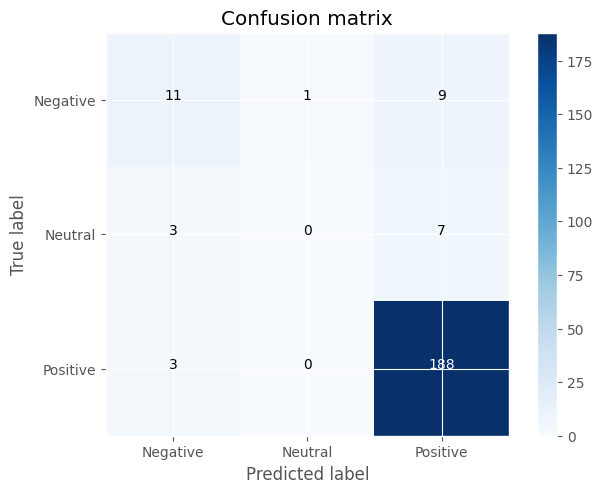

In [24]:
best_LR = hypertuning(classifier = LR, 
                      param_grid = lr_params, 
                      metric='accuracy', 
                      verbose_value=1)

#### Tuning Random Forest

In [14]:
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)
print(f'Base RF accuracy on test set is: {accuracy_score(y_test, y_pred)}')
print(f'Base RF F1 score on test set is: {f1_score(y_test, y_pred, average="weighted")}')

Base RF accuracy on test set is: 0.8738738738738738
Base RF F1 score on test set is: 0.8401881358970912


In [15]:
# define the hyperparameter space
rf_params = {
    'bootstrap': [True],
    'max_depth': [5, 10, 20, 25, 30],
    'min_samples_leaf': [1, 2, 4, 8],    # Minimum number of samples required to be at a leaf node
    'min_samples_split': [2, 5, 10],     # Minimum number of samples required to split an internal node
    'n_estimators': [100, 200, 400],
}

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Score: 0.9837692641632299
Hyperparameter set:
	bootstrap: True
	max_depth: 25
	min_samples_leaf: 1
	min_samples_split: 5
	n_estimators: 200
Tuned LR accuracy on test set is: 0.8783783783783784
Tuned LR F1 score on test set is: 0.8346395037571508


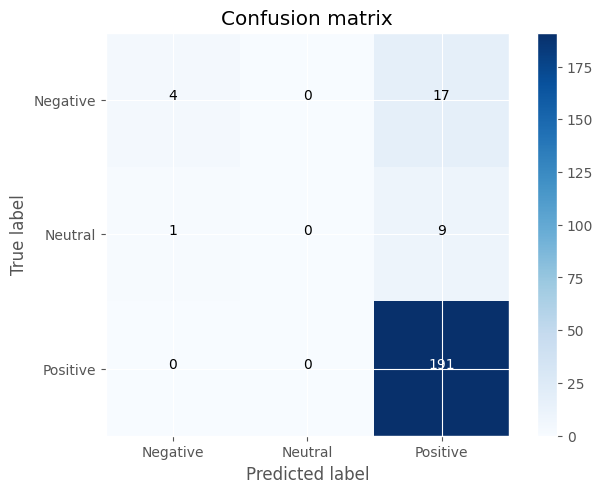

In [25]:
best_RF = hypertuning(classifier = RF, 
                      param_grid = rf_params, 
                      metric='accuracy', 
                      verbose_value=1)

#### Tuning Support Vector Machine Classifier

In [17]:
SV.fit(X_train, y_train)
y_pred = SV.predict(X_test)
print(f'Base SVC accuracy on test set is: {accuracy_score(y_test, y_pred)}')
print(f'Base SVC F1 score on test set is: {f1_score(y_test, y_pred, average="weighted")}')

Base SVC accuracy on test set is: 0.8693693693693694
Base SVC F1 score on test set is: 0.8220595167294433


In [18]:
# define the hyperparameter space
svc_params = {
    'C': [0.1, 1, 10],  # error term parameter
    'kernel': ['linear', 'rbf']
}

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Score: 1.0
Hyperparameter set:
	C: 1
	kernel: rbf
Tuned LR accuracy on test set is: 0.8693693693693694
Tuned LR F1 score on test set is: 0.8220595167294433


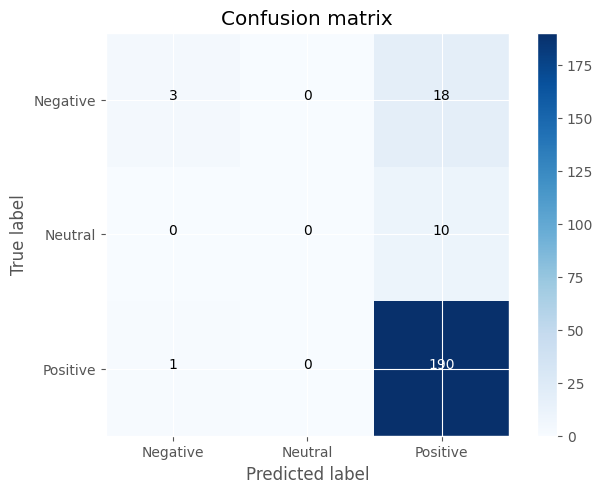

In [26]:
best_SVC = hypertuning(classifier = SV, 
                      param_grid = svc_params, 
                      metric='accuracy', 
                      verbose_value=1)

On the main diagonal we can see the correctly classified reviews. As expected from the analysis of the sentences, reviews, whether they are negative, neutral or positive, tend to be classified as positive. But I would say this is pretty much normal, even after the SMOTE balancing, since the reviews (with regard to their sentiment) are not that easy to classify.

#### Tuning XGBOOST

In [20]:
XGB.fit(X_train, y_train)
y_pred = XGB.predict(X_test)
print(f'Base XGB accuracy on test set is: {accuracy_score(y_test, y_pred)}')
print(f'Base XGB F1 score on test set is: {f1_score(y_test, y_pred, average="weighted")}')

Base XGB accuracy on test set is: 0.8918918918918919
Base XGB F1 score on test set is: 0.8657748200461769


In [21]:
# XGB.get_params()
# defining some of the hyperparameters
xgb_params = {
        'max_depth': [3,5,7,9],
        'min_child_weight': [1, 5, 10],
        'scale_pos_weight': [1, 2, 3],          # Balancing of positive and negative weights
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],           # Subsample ratio of the training instances
        'colsample_bytree': [0.5, 0.8, 1.0],    # Subsample ratio of columns for constructing each tree
        'reg_alpha': [0, 0.01, 0.1],            # L1 regularization term on weights
        'reg_lambda': [0, 0.01, 0.1],           # L2 regularization term on weights
        'max_depth': [3, 4, 5],
        'learning_rate': [0.1, 0.01, 0.001],
        'n_estimators': [100, 200, 300]         # Number of boosting rounds
        }

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[13:14:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

Best Score: 0.9764054699370524
Hyperparameter set:
	colsample_bytree: 0.5
	gamma: 2
	learning_rate: 0.1
	max_depth: 5
	min_child_weight: 5
	n_estimators: 100
	reg_alpha: 0.1
	reg_lambda: 0
	scale_pos_weight: 1
	subsample: 1.0
Tuned LR accuracy on test set is: 0.8918918918918919
Tuned LR F1 score on test set is: 0.8707923572427388


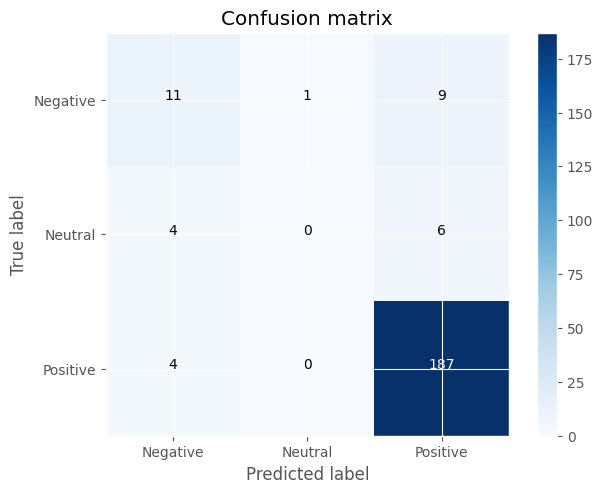

In [27]:
best_XGB = hypertuning(classifier = XGB, 
                      param_grid = xgb_params, 
                      metric='accuracy', 
                      verbose_value=1)

Our LR is better than the XGBoost.

### Results

In [28]:
tuned_crossval_dict = {0: 'Logistic Regression',
                       1: 'SVC',
                       2: 'Random Forest',
                       3: 'XGBoost'}
tuned_crossval_models=[best_LR, best_SVC, best_RF, best_XGB]
crossval_models = [LR, SV, RF, XGB]

In [31]:
print('---------BASE MODELS RESULTS ON TEST SET---------')
results = []
for i, model in enumerate(crossval_models):
    accuracy = model.score(X_test, y_test)
    precision = precision_score(y_test, model.predict(X_test), average="micro")
    f1 = f1_score(y_test, model.predict(X_test), average="weighted")
    results.append({'Model': tuned_crossval_dict[i], 'Accuracy': accuracy, 'Precision': precision, 'F1': f1})
df_results = pd.DataFrame(results)
df_results

---------BASE MODELS RESULTS ON TEST SET---------


,Model,Accuracy,Precision,F1
0,Logistic Regression,0.900901,0.900901,0.882727
1,SVC,0.869369,0.869369,0.822060
2,Random Forest,0.873874,0.873874,0.840188
3,XGBoost,0.891892,0.891892,0.865775


In [32]:
print('---------FINAL TUNED RESULTS ON TEST SET---------')
results = []
for i, model in enumerate(tuned_crossval_models):
    accuracy = model.score(X_test, y_test)
    precision = precision_score(y_test, model.predict(X_test), average="micro")
    f1 = f1_score(y_test, model.predict(X_test), average="weighted")
    results.append({'Model': tuned_crossval_dict[i], 'Accuracy': accuracy, 'Precision': precision, 'F1': f1})
df_results = pd.DataFrame(results)
df_results

---------FINAL TUNED RESULTS ON TEST SET---------


,Model,Accuracy,Precision,F1
0,Logistic Regression,0.896396,0.896396,0.873741
1,SVC,0.869369,0.869369,0.822060
2,Random Forest,0.878378,0.878378,0.834640
3,XGBoost,0.891892,0.891892,0.870792


Knowing that we begun from a set of overfitted models, these results are good. The logistic regression is our preferred model.

#### ROC-AUC curve

The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve(Receiver Operating Curve). Here I plotted the Logistic Regression ROC for the 3 different classes and through that we can understand which class was classified better. Also we plot micro and macro averages on the roc curve.

In [ ]:
# multi-class classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=3, n_features=20, n_informative=3, random_state=42)

# split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# fit model
clf = OneVsRestClassifier(LogisticRegression())
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
pred_prob = clf.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300)

3

- Considering the ROC curve for classes, class 2 and 0 have been classified pretty well a their area under the curve is high. We can chose any threshold between 0.6-0.8 to get the optimal number of TPR (True Positive Rate) and FPR (False Positive Rate).
- Coming to micro and macro average, micro average preforms really well and macro average shows a not very good score. A macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally), whereas a micro-average will aggregate the contributions of all classes to compute the average metric. In a multi-class classification setup, micro-average is preferable if there might be class imbalance, as in our case.

## VADER


compound of vader is 10x better than the textblob polarities

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [ ]:
sia

In [ ]:
# run on entire dataset
results = {}
for i, row in df.iterrows():
    text = row['Review']
    Id = i
    results[Id] = sia.polarity_scores(text)

In [ ]:
vaders = pd.DataFrame(results).T
vaders = vaders.reset_index().rename(columns={'index': 'Id',
                                              'neg': 'Vaders neg',
                                              'neu': 'Vaders neu',
                                              'pos': 'Vaders pos',
                                              'compound': 'Vaders compound'})

df['Id'] = range(df.shape[0])
vaders = vaders.merge(df, how='left')
vaders.head(1)

,Id,Vaders neg,Vaders neu,Vaders pos,Vaders compound,Clean Review,Review,Title,Content,Rating,Sentiment,Year,Month,Day,TB Polarity,Review Length,Word Count,Target
0,0,0.0,0.505,0.495,0.8687,good sound seem decent build quality good sou...,good sound. seem decent build quality and good...,good sound,seem decent build quality and good sound. very...,5,Positive,2023,5,28,0.561111,79,13,2


Compound is an aggregation of the 3, goes from -1 to 1.

Is this in line with what we expect? If the rating is 5-4, is the rating positive?

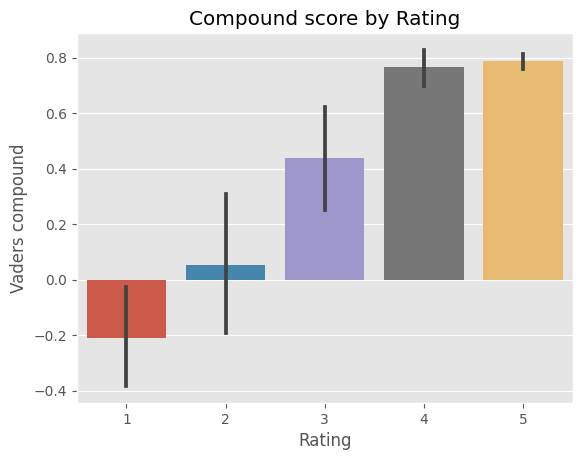

In [ ]:
ax = sns.barplot(data=vaders, x='Rating', y='Vaders compound')
ax.set_title('Compound score by Rating')
plt.show()

It is what we would expect!

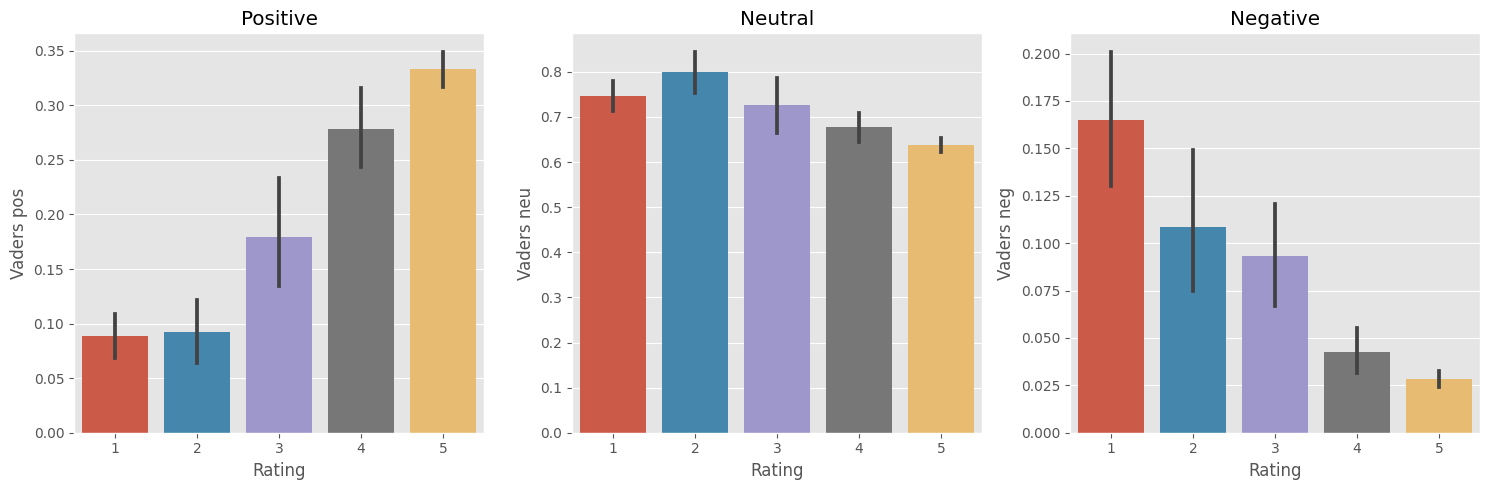

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
sns.barplot(data = vaders, x='Rating', y='Vaders pos', ax = axs[0])
sns.barplot(data = vaders, x='Rating', y='Vaders neu', ax = axs[1])
sns.barplot(data = vaders, x='Rating', y='Vaders neg', ax = axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

## RoBERTa

### The Transformers Pipeline

In [ ]:
# from transformers import pipeline

# sent_pipeline = pipeline("sentiment-analysis")

In [ ]:
sent_pipeline = ('phrase')